<a href="https://colab.research.google.com/github/Shashank1202/Deep_Learning/blob/main/SimpleGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's Play with Simple GANs by implementing them from scratch using fully connected layers.

In [1]:
!pip install torch torchvision tensorboard

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard import writer

In [3]:
class Discriminator(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.disc= nn.Sequential(
        nn.Linear(in_features, 128),
        nn.LeakyReLU(0.01),
        nn.Linear(128, 1),
        nn.Sigmoid(),
    )
  def forward(self, x):
    return self.disc(x)

In [4]:
class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.gen= nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.01),
        nn.Linear(256, img_dim),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.gen(x)

In [5]:
#Hyperparameters etc

device= "cuda" if torch.cuda.is_available() else "cpu"
lr= 3e-4
z_dim= 64
image_dim= 28*28*1
batch_size= 32
num_epochs= 50

In [6]:
disc= Discriminator(image_dim).to(device)
gen= Generator(z_dim, image_dim).to(device)
fixed_noise= torch.randn(batch_size, z_dim).to(device)
transforms= transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [7]:
dataset= datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader= DataLoader(dataset, batch_size= batch_size, shuffle= True)
opt_disc= optim.Adam(disc.parameters(), lr=lr)
criterion= nn.BCELoss()

writer_fake= SummaryWriter(f"logs/fake")
writer_real= SummaryWriter(f"logs/real")
step=0

In [8]:
for epoch in range(num_epochs):
  for batch_idx, (real,_) in enumerate(loader):
    real= real.view(-1, 784).to(device)
    batch_size=real.shape[0]

    #Train Discriminator: max log(D(x)) + log(1- D(G(z)))
    noise= torch.randn(batch_size, z_dim).to(device)
    fake= gen(noise)
    disc_real= disc(real).view(-1)
    lossD_real= criterion(disc_real, torch.ones_like(disc_real))
    disc_fake= disc(fake).view(-1)
    lossD_fake= criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD= (lossD_real + lossD_fake)/2
    disc.zero_grad()
    lossD.backward(retain_graph= True)
    opt_disc.step()

    #Trainning the Generator : min log(1-D(G(z))) <-> max log(D(G(z)))
    output= disc(fake).view(-1)
    lossG= criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_disc.step()

    if batch_idx==0:
      print(
          f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)}\
          Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
      )
      with torch.no_grad():
        fake= gen(fixed_noise).reshape(-1, 1, 28, 28)
        data= real.reshape(-1, 1, 28, 28)
        img_grid_fake= torchvision.utils.make_grid(fake, normalize= True)
        img_grid_real= torchvision.utils.make_grid(data, normalize= True)

        writer_fake.add_image(
            "Mnist Fake Images", img_grid_fake, global_step=step
        )
        writer_real.add_image(
            "Mnist Real Images",img_grid_real, global_step=step
        )
        step+=1

writer_fake.close()
writer_real.close()

Epoch [0/50] Batch 0/1875          Loss D: 0.6923, loss G: 0.7286
Epoch [1/50] Batch 0/1875          Loss D: 0.3460, loss G: 0.6944
Epoch [2/50] Batch 0/1875          Loss D: 0.3465, loss G: 0.6934
Epoch [3/50] Batch 0/1875          Loss D: 0.3462, loss G: 0.6941
Epoch [4/50] Batch 0/1875          Loss D: 0.3462, loss G: 0.6940
Epoch [5/50] Batch 0/1875          Loss D: 0.3463, loss G: 0.6937
Epoch [6/50] Batch 0/1875          Loss D: 0.3463, loss G: 0.6938
Epoch [7/50] Batch 0/1875          Loss D: 0.3461, loss G: 0.6942
Epoch [8/50] Batch 0/1875          Loss D: 0.3463, loss G: 0.6937
Epoch [9/50] Batch 0/1875          Loss D: 0.3463, loss G: 0.6938
Epoch [10/50] Batch 0/1875          Loss D: 0.3464, loss G: 0.6937
Epoch [11/50] Batch 0/1875          Loss D: 0.3463, loss G: 0.6938
Epoch [12/50] Batch 0/1875          Loss D: 0.3463, loss G: 0.6937
Epoch [13/50] Batch 0/1875          Loss D: 0.3462, loss G: 0.6940
Epoch [14/50] Batch 0/1875          Loss D: 0.3464, loss G: 0.6936
Epoch

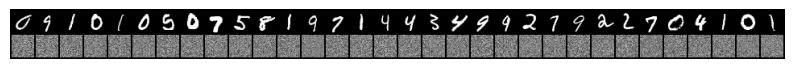

In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

with torch.no_grad():
  generated_images= gen(fixed_noise).detach().cpu()

  real_images, _= next(iter(loader))
  real_images= real_images[:batch_size].reshape(-1, 1, 28, 28)

  real_images = real_images.squeeze(1)
  generated_images = generated_images.view(-1, 1, 28, 28)
  images_to_show = torch.cat([real_images.unsqueeze(1), generated_images], dim=0)

  img_grid= vutils.make_grid(images_to_show, normalize= True, nrow=batch_size)

  plt.figure(figsize=(10, 5))
  plt.imshow(img_grid.permute(1, 2, 0))
  plt.axis("off")
  plt.show()